# Support Vector Regression

We select support vector regression mainly because they are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.

We use Leave on Out CV for the model because we are limited in the number of observations (countries)

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load all datasets
def load_created_datasets():
    data_list = []
    DATA_PATH = Path('./data/created/')
    
    file_paths = DATA_PATH.glob('*.csv')
    for file_path in file_paths:
        df = pd.read_csv(file_path, index_col='Country')
        data_list.append(df)
    return pd.concat(data_list, join='inner', axis=1)
data = load_created_datasets()
data.shape

(42, 40)

In [3]:
# todo: why 42 I thought we only have 37 equal county names

In [4]:
data.describe()

,Artificial surfaces,Bare area,Cropland,Grassland,Inland water,Shrubland,Sparse vegetation,Tree cover,Wetland,perc_area_protected_all_obj,...,N2O,NF3,PFC,SF6,total_threatened,mammals_threatened,insects_threatened,amphibians_threatened,birds_threatened,reptiles_threatened
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.026339,0.038424,0.310657,0.119879,0.024451,0.046523,0.042569,0.372816,0.018343,22.282857,...,0.586226,-0.666490,-0.154093,-0.036179,0.090214,0.101226,0.093860,0.127510,0.058579,0.113638
std,0.027342,0.101581,0.200676,0.146812,0.025092,0.089805,0.090189,0.200493,0.028890,10.766357,...,0.349903,0.477372,0.384327,0.219119,0.059176,0.069002,0.059323,0.179915,0.042883,0.150635
min,0.000000,0.000000,0.000000,0.000538,0.001644,0.000000,0.000000,0.000277,0.000000,5.640000,...,0.092906,-1.000000,-1.000000,-1.000000,0.016700,0.000000,0.000000,0.000000,0.016000,0.000000
25%,0.005924,0.000336,0.129256,0.037745,0.010373,0.000000,0.000336,0.240079,0.001003,14.287500,...,0.345235,-1.000000,0.000021,0.002429,0.050675,0.051750,0.065525,0.000000,0.038250,0.000000
50%,0.015773,0.003751,0.284342,0.067105,0.016106,0.001209,0.004243,0.359648,0.003297,20.370000,...,0.481730,-1.000000,0.003712,0.007283,0.071400,0.089700,0.086850,0.032150,0.044300,0.077000
75%,0.040661,0.025580,0.453853,0.145471,0.023636,0.042408,0.026137,0.531033,0.020536,27.892500,...,0.849686,0.000009,0.012341,0.010464,0.124150,0.142075,0.103925,0.209625,0.064075,0.158400
max,0.113337,0.566080,0.728131,0.672711,0.105244,0.352494,0.357313,0.714984,0.123473,53.530000,...,1.554079,0.002234,0.216726,0.128989,0.357500,0.294000,0.304300,0.750000,0.290000,0.750000


In [5]:
# are there any missing numbers
data.isna().any().sum()

0

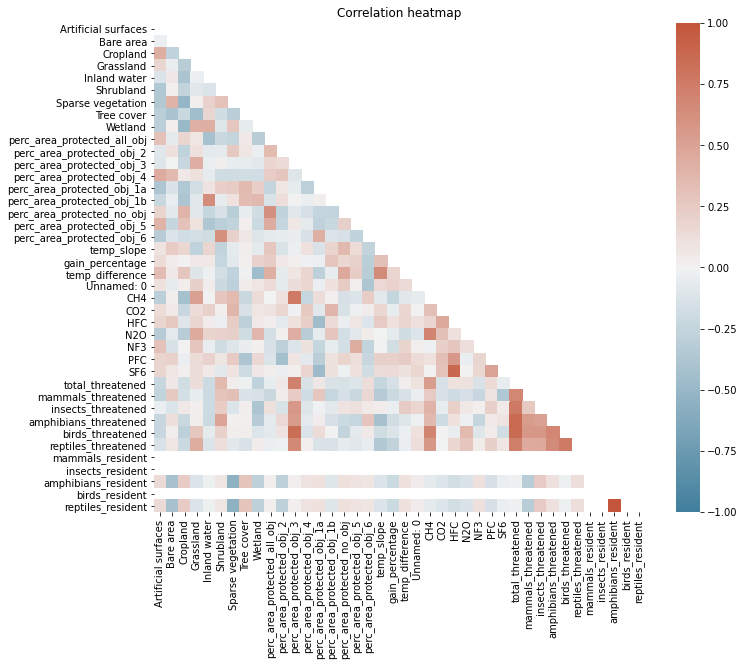

In [6]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Compute the correlation matrix
corr = data.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# create heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

In [7]:
columns_threatened = [col for col in data.columns if col.endswith('threatened')]
columns_threatened

['total_threatened',
 'mammals_threatened',
 'insects_threatened',
 'amphibians_threatened',
 'birds_threatened',
 'reptiles_threatened']

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# predict all threatend relative species by group using a SVR
def svr_predict_threatened(data):
    results = {}

    # iterate all tartget veriables
    columns_threatened = [col for col in data.columns if col.endswith('threatened')]
    for target in columns_threatened:
        y = data[target]
        X = data.drop(columns=columns_threatened)

        # create pipeline for Model
        svr = Pipeline([
            # ('scaling', StandardScaler()), # worse model with scaling ?
            ('svr', SVR())
        ])

        # define grid search parameters
        params = {
            'svr__C': [0.1, 0.4, 1, 5, 10], # todo: inform on parameter ranges
            'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }


        svm_grid_search = GridSearchCV(svr,
                                        cv=LeaveOneOut(),
                                        param_grid=params,
                                        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                                        refit='neg_mean_squared_error')
        svm_grid_search.fit(X, y)

        results[target] = -svm_grid_search.best_score_

    return results
svr_scores = svr_predict_threatened(data)
svr_scores

{'total_threatened': 0.004824535661834768,
 'mammals_threatened': 0.005029050055562802,
 'insects_threatened': 0.00409549077238054,
 'amphibians_threatened': 0.031121092048219497,
 'birds_threatened': 0.004483321780127271,
 'reptiles_threatened': 0.022082212740448418}